In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.notebook import tqdm
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import cv2
from torchvision.utils import save_image
from torchvision.utils import make_grid
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batchsize = 128
latent_size = 100

In [ ]:
training_data = dset.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose ([ 
        transforms.Scale(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size= batchsize, shuffle=True, num_workers=2) 

In [ ]:
def weight_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)  

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.g = nn.Sequential(
        nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False),
        nn.Tanh()
    )
  def forward(self, input):
    fake = self.g(input)
    return fake

In [ ]:
netGen = Generator()
netGen.apply(weight_init)

Generator(
  (g): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.d = nn.Sequential(
        nn.Conv2d(3, 64, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(64, 128, 4, 2, 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True), 
        nn.Conv2d(128, 256, 4, 2, 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(256, 512, 4, 2, 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(512, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )
  def forward(self, input):
    ans = self.d(input)
    return ans.view(-1) 

In [ ]:
netDis = Discriminator()
netDis.apply(weight_init)

Discriminator(
  (d): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
criterion = nn.BCELoss()
optDis = optim.Adam(netDis.parameters(), lr=0.0002, betas = (0.5, 0.999))
optGen = optim.Adam(netGen.parameters(), lr=0.0002, betas = (0.5, 0.999))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
netDis.to(device)
netGen.to(device)

Generator(
  (g): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [ ]:
real_score = []
fake_score = []
epochs = 88
losses_g = []
losses_d = []
for epoch in range(epochs):
  loss_d_tmp = []
  loss_g_tmp = []
  real_score_tmp = []
  fake_score_tmp = []
  for real_image, i in tqdm(train_loader):
    netDis.zero_grad()
    real_image = real_image.to(device)
    real_image = Variable(real_image)
    real_preds = netDis(real_image)
    #присвоим реальному изображению метку класса 1
    real_targets = Variable(torch.ones(real_image.size()[0], device=device)) 
    #учим дисриминатор предсказывать эту метку класса
    real_loss = criterion(real_preds, real_targets)
    #берем латентный вектор
    latent = Variable(torch.randn(real_image.size()[0], latent_size, 1, 1, device=device))
    #генерируем изображение
    fake_image = netGen(latent)
    #присваимваем метку класса 0
    fake_targets = Variable(torch.zeros(real_image.size()[0], device=device))
    #подвем в дискриминатор, считаем лосс
    fake_preds = netDis(fake_image)
    fake_loss = criterion(fake_preds, fake_targets)
    #считаем скор и делаем шаг
    real_score_tmp.append(torch.mean(real_preds).item())
    fake_score_tmp.append(torch.mean(fake_preds).item())
    loss_d = real_loss + fake_loss
    loss_d.backward()
    optDis.step()
    loss_d_tmp.append(loss_d.item())
    #обучим генератор
    netGen.zero_grad()
        
    #генерируем изображение
    latent = torch.randn(real_image.size()[0], latent_size, 1, 1, device=device)
    fake_image = netGen(latent)
        
    #подаем изображение дискриминатору 
    preds = netDis(fake_image)
    targets = Variable(torch.ones(real_image.size()[0], device=device))
    #считаем лосс генератора 
    loss_g = criterion(preds, targets)
    # делаем шаг
    loss_g.backward()
    optGen.step()
    loss_g_tmp.append(loss_g.item())
  #if (epoch % 5 == 1):  
    fake_image = netGen(latent) 
    vutils.save_image(fake_image.data, '%s/fake_samples_epoch_%03d.png' % ("/content/data", epoch), normalize = True)
    torch.save(netGen, "model_gen" + str(epoch) + ".zip")
    torch.save(netDis, "model_dis" + str(epoch) + ".zip")
  print(f'loss generator on {epoch} = {np.mean(loss_g_tmp)}')
  print(f'real scores on {epoch} = {np.mean(real_score_tmp)}')
  print(f'fake scores on {epoch} = {np.mean(fake_score_tmp)}')
  losses_g.append(np.mean(loss_g_tmp))
  losses_d.append(np.mean(loss_d_tmp))
  real_score.append(np.mean(real_score_tmp))
  fake_score.append(np.mean(fake_score_tmp))

  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 74 = 2.9690675979380106
real scores on 74 = 0.9941344099581394
fake scores on 74 = 0.08113107398685897


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 75 = 2.9376922220830113
real scores on 75 = 0.9942326780475313
fake scores on 75 = 0.0810278252700863


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 76 = 2.937897429136974
real scores on 76 = 0.9941446993052198
fake scores on 76 = 0.0802112503448868


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 77 = 2.962491102535706
real scores on 77 = 0.994119704074567
fake scores on 77 = 0.07888288830247377


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 78 = 2.948184508496843
real scores on 78 = 0.9941107705426033
fake scores on 78 = 0.07990832387676934


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 79 = 2.952900595067407
real scores on 79 = 0.994189946395357
fake scores on 79 = 0.08075165053081634


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 80 = 2.9451216242807297
real scores on 80 = 0.9940878665050887
fake scores on 80 = 0.07964400692707133


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 81 = 2.9509359113395672
real scores on 81 = 0.9941541576934287
fake scores on 81 = 0.07968426189001869


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 82 = 2.973664908762783
real scores on 82 = 0.9941532849655736
fake scores on 82 = 0.07885602702531973


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 83 = 2.9665701291750155
real scores on 83 = 0.9941307227020069
fake scores on 83 = 0.08003543150108641


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 84 = 2.9496212828799586
real scores on 84 = 0.9941880626751639
fake scores on 84 = 0.07821530214203593


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 85 = 2.9379876574591908
real scores on 85 = 0.9941888398221691
fake scores on 85 = 0.07980400944114341


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 86 = 2.9464876163950966
real scores on 86 = 0.994080199609937
fake scores on 86 = 0.07882425121372313


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 87 = 2.9614533323156254
real scores on 87 = 0.9942020815046851
fake scores on 87 = 0.0811165787584489


  0%|          | 0/391 [00:00<?, ?it/s]

loss generator on 88 = 2.929760471939126
real scores on 88 = 0.9941402737746763
fake scores on 88 = 0.07969170653492288


  0%|          | 0/391 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
netDis = torch.load("model_dis50.zip")
netGen = torch.load("model_gen50.zip")

In [ ]:
fake_image = netGen(latent) 
vutils.save_image(fake_image.data, '%s/fake_samples_epoch_%03d.png' % ("/content/data/res", 25), normalize = True)

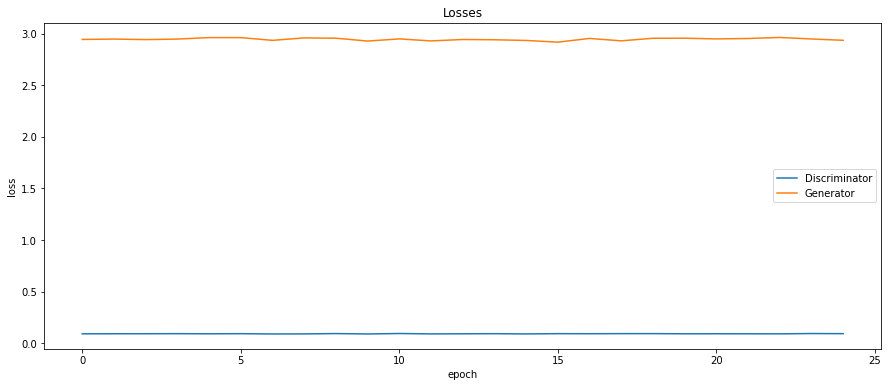

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

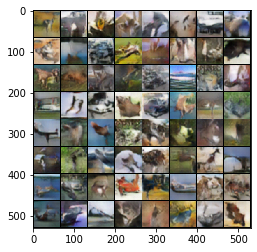

In [ ]:
import imageio
img = imageio.imread('/content/data/res/fake_samples_epoch_025.png')
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img, interpolation='nearest')
plt.show()

In [ ]:
pip install pytorch-gan-metrics

     |████████████████████████████████| 25.9 MB 1.2 MB/s 
  Created wheel for pytorch-gan-metrics: filename=pytorch_gan_metrics-0.4.1-py3-none-any.whl size=17524 sha256=5848e8b5ea956c41bc508b3c2fa845c652073f71f28a79660a1e0f7b59596d49
  Stored in directory: /root/.cache/pip/wheels/60/6a/0f/5266df3028505c4d35deff810633775536b955f8264f62c772
Successfully built pytorch-gan-metrics
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from torchvision.models.inception import inception_v3
import numpy as np
from pytorch_gan_metrics import get_inception_score

In [ ]:
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 50000
    
    def __getitem__(self, index):
        return self.G(torch.randn(64, latent_size, 1, 1, device=device))[0]

dataset = GeneratorDataset(netGen, latent_size)
loader = DataLoader(dataset, batch_size=64, num_workers=0)

In [ ]:
IS, IS_std = get_inception_score(loader)

In [ ]:
print(IS)

5.006393481596719
